In [1]:
import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
import importlib as imp
import seaborn as sns
from tifffile import TiffFile
import umap
from tqdm import tqdm

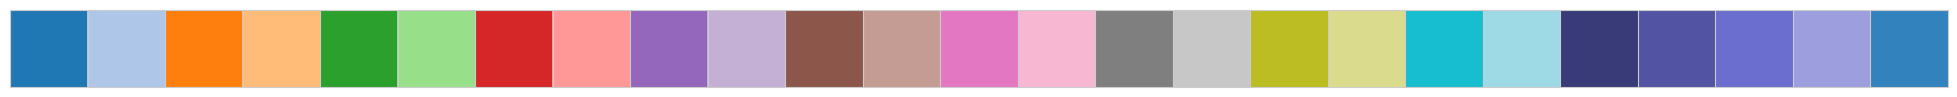

In [2]:
cmap1 = plt.get_cmap("tab20")
cmap2 = plt.get_cmap("tab20b")
cmap3 = plt.get_cmap("tab20c")
colors1 = cmap1.colors
colors2 = cmap2.colors
colors3 = cmap3.colors
contrast_palette = sns.color_palette(list(colors1) + list(colors2[:4]) + list(colors3[:1]))
del cmap1, cmap2, cmap3, colors1, colors2, colors3
sns.palplot(contrast_palette)

In [3]:
adata_xe = sc.read_h5ad("results/Xenium/adata_xe.h5ad")
img_xe = np.load('results/Xenium/Xenium_resize_Affine.npy')
img_HE = cv.imread('F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/Sample221.jpg')
img_HE = img_HE[:, :, [2, 1, 0]]
img_xe = img_xe/1500
img_xe[img_xe>1] = 1
img_xe = np.expand_dims(img_xe, axis=2)
img_xe = np.repeat(img_xe, 3, axis=2)
ratio = 2
img_xe_resize = cv.resize(img_xe, None, fx=ratio, fy=ratio, interpolation=cv.INTER_CUBIC)
loc_xe = adata_xe.obs[['x_centroid', 'y_centroid']].values
loc_xe_resize = loc_xe * ratio
type_list = adata_xe.uns['type_list']
palette_dict = dict(zip(map(str, type_list), contrast_palette))

In [4]:
# img_xe_anno = img_xe_resize.copy()
img_xe_anno = np.zeros_like(img_xe_resize)
for loc, cell_type in tqdm(zip(loc_xe_resize, adata_xe.obs['cell_type'].values)):
    color = palette_dict[cell_type]
    color = np.array(color)[[2, 1, 0]]
    loc = loc.astype(np.int32)
    if 0<=loc[0]<=len(img_xe_anno[0]) and 0<=loc[1]<=len(img_xe_anno[1]):
        cv.circle(img_xe_anno, loc, 10, color, -1)
# cv.imwrite('results/Xenium/Xenium_annotation.png', img_xe_anno*255)

104831it [00:01, 69741.40it/s]


In [4]:
img_xe_anno = [np.zeros_like(img_xe_resize) for i in range(len(type_list))]
for loc, cell_type in tqdm(zip(loc_xe_resize, adata_xe.obs['cell_type'].values)):
    idx = np.where(type_list==cell_type)[0][0]
    color = palette_dict[cell_type]
    color = np.array(color)[[2, 1, 0]]
    loc = loc.astype(np.int32)
    if 0<=loc[0]<=len(img_xe_anno[idx][0]) and 0<=loc[1]<=len(img_xe_anno[idx][1]):
        cv.circle(img_xe_anno[idx], loc, 10, color, -1)
for i in range(len(type_list)):
    cell_type = type_list[i]
    cell_type = "".join(x for x in cell_type if x.isalnum())
    cv.imwrite('results/Xenium/Annotation/Annotation'+cell_type+'.png', img_xe_anno[i]*255)

104831it [00:02, 45832.63it/s]


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(1, 7), dpi=300)
for i, cell_type in enumerate(type_list):
    plt.text(0, (22-i)/4, cell_type)
    rectangle = mpl.patches.Rectangle([-1.8, (22-i)/4-0.04], 1.5, 0.18, facecolor=contrast_palette[i])
    ax.add_patch(rectangle)
plt.ylim(0, 23/4)
plt.xlim(-2, 1)
ax.axis('off')
plt.savefig('results/color_label.png', dpi=1000, bbox_inches = 'tight')

In [5]:
ratio_xe_cos = 0.7528/0.1644
loc_fov = pd.read_csv('F:/Ziqian Zheng/Spotiphy_data/CosMx/Raw_data_MsBrain/R5539_Ms2CD/R5539_Ms2CD_fov_positions_file.csv', index_col=0).values
# loc_fov = loc_fov[:, [1, 0]]
shift = np.min(loc_fov-100, axis=0)
loc_fov -= shift
n_fov = len(loc_fov)

In [6]:
theta = 3.2
trans = np.array([28000, 23850])
M = np.float32([[np.cos(theta), -np.sin(theta), trans[0]], [np.sin(theta), np.cos(theta), trans[1]]])
loc_fov = loc_fov @ M[:, :2].T + trans
loc_fov = loc_fov/ratio_xe_cos

In [7]:
img_xe_anno_copy = img_xe_anno.copy()
rectangle_size = np.array([3648, 5472])/ratio_xe_cos*ratio
for loc in loc_fov*ratio:
    v = np.diag(rectangle_size) @ M[:, [1, 0]]
    pts = np.vstack((loc, loc + v[1], loc + v[0] + v[1], loc + v[0])).astype(np.int32)
    if np.min(pts) > 0:
        pts = pts.reshape((-1, 1, 2))
        # cv.fillPoly(img_HE_copy, [pts], (0, 0, 0))
        cv.polylines(img_xe_anno_copy, [pts], True, (0, 0, 1), 40)
cv.imwrite('results/Xenium/Xenium_annotation_fov.png', img_xe_anno_copy*255)

True

In [44]:
adata_xe_copy = adata_xe.copy()
adata_xe_copy.obs['fov'] = -1

In [45]:
%%time
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
for i, loc in enumerate(loc_fov*ratio):
    v = np.diag(rectangle_size) @ M[:, [1, 0]]
    polygon = Polygon(np.vstack((loc, loc + v[1], loc + v[0] + v[1], loc + v[0])))
    for j, loc_neu in enumerate(loc_xe_resize):
        if polygon.contains(Point(loc_neu)):
            adata_xe_copy.obs.iloc[j, adata_xe_copy.obs.columns.get_loc('fov')] = i+1

CPU times: total: 47.8 s
Wall time: 47.8 s


In [46]:
adata_xe_copy.obs['fov'].value_counts()

fov
-1     84367
 16     2383
 15     2280
 14     2152
 20     2140
 13     2076
 19     1945
 12     1849
 17     1804
 11     1770
 18     1726
 10      339
Name: count, dtype: int64

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

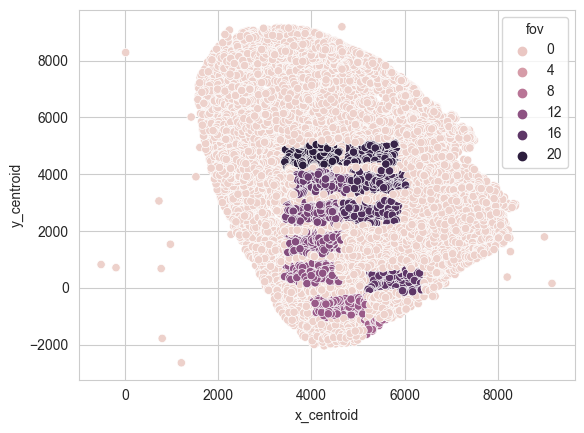

In [47]:
sns.scatterplot(data = adata_xe_copy.obs[::10], x='x_centroid', y='y_centroid', hue='fov')

In [51]:
summary_df = pd.DataFrame({'fov':np.arange(1, 21), 'x':loc_fov[:, 0], 'y':loc_fov[:, 1]})
summary_df[type_list] = 0
for fov, cell_type in zip(adata_xe_copy.obs['fov'], adata_xe_copy.obs['cell_type']):
    if fov>=0:
        summary_df.at[fov-1, cell_type] += 1
summary_df.to_csv('results/Xenium/Xenium_annotation_summary.csv')

In [52]:
summary_df

,fov,x,y,Astro,CR,Endo,L2/3 IT,L5 ET,L5 IT,L5/6 NP,...,OPC,Oligo,Peri,Prog/IP,Pvalb,SMC,Sncg,Sst,VLMC,Vip
0,1,-4403.073220,1225.802418,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,-6037.606100,1099.841961,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,-4399.150514,2260.269714,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,-6076.605254,2244.824276,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,-4403.635241,3293.030075,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,-6777.518166,3236.861796,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,-4742.405497,4306.243472,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,8,-6822.234681,4126.292447,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,-7379.685499,2186.857961,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,6332.033126,-1021.923315,47,0,13,2,1,28,1,...,3,24,1,0,8,0,0,7,0,1
